# Descriptive analysis

## Plain English Summary

tbc

## Aims

tbc

## Observations

tbc

<mark>Be sure to include median, quartile, IQR. Use violin plots instead of boxplots, and set whiskers as range rather than marking outliers</mark>

## Set up

In [1]:
# Linting
%load_ext pycodestyle_magic
%pycodestyle_on

In [2]:
# Import packages and functions
from dataclasses import dataclass
import matplotlib.pyplot as plt
import os
import pandas as pd

In [3]:
# Set paths and filenames
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and files.'''

    data_path = './../output/'
    data_filename = 'reformatted_data.csv'
    restrict_filename = 'reformatted_data_restricted.csv'
    notebook = '01'


paths = Paths()

In [4]:
# Load data
raw_data = pd.read_csv(os.path.join(paths.data_path, paths.data_filename))

## Restrict years and remove very small centres

Restrict to:
* Records from 2017, 2018 and 2019
* Stroke teams with at least an average of 100 stroke admissions and 3 thrombolysis patients per year - hence, removing where less than 300 admissions or 9 patients

In [5]:
# Restrict to records from 2017 to 2019
raw_data_restrict = raw_data[raw_data['year'].isin([2017, 2018, 2019])]

# Loop through name (each stroke team) and group_df (relevant rows from data)
# Identify if meet conditions and save to appropriate list
keep = []
discard = []
groups = raw_data_restrict.groupby('stroke_team')
for name, group_df in groups:
    # Skip if admissions less than 300 or thrombolysis patients less than 9
    raw_admissions = len(group_df.index)
    raw_thrombolysis_received = group_df['thrombolysis'] == 1
    if (raw_admissions < 300) or (raw_thrombolysis_received.sum() < 9):
        discard.append(group_df)
        continue
    else:
        keep.append(group_df)

# Concatenate output
data = pd.concat(keep)

In [6]:
# Save restricted dataset
filename = os.path.join(paths.data_path, paths.restrict_filename)
data.to_csv(filename)

In [7]:
# Printing change in number of records due to restricting years
print(f'''
Number of records per year:
{raw_data.year.value_counts().sort_index().to_string()}
Total records (all years): {len(raw_data.index)}
Total records (2017-19): {len(raw_data_restrict.index)}''')

# Printing number of stroke teams kept v.s. removed
print('Number of stroke teams remaining in dataset: {0}'.format(len(keep)))
print('Number of stroke teams removed from dataset: {0}'.format(len(discard)))


Number of records per year:
2016    56274
2017    58732
2018    58314
2019    60181
2020    59082
2021    66410
Total records (all years): 358993
Total records (2017-19): 177227
Number of stroke teams remaining in dataset: 114
Number of stroke teams removed from dataset: 4


#### Reflections regarding current restrictions

<mark>To consider:</mark> Ambition of restriction is to remove locations that aren't really stroke units. However, current restrictions remove centres with a reasonble number of admissions (e.g. apx. 100 per year), and so should be reconsidered.

In [8]:
discard_df = pd.concat(discard)
discard_summary = (discard_df.groupby(['stroke_team', 'year'])['thrombolysis']
                   .value_counts()
                   .reset_index(name='count'))
discard_summary.merge(
    discard_df.groupby(['stroke_team', 'year']).size().reset_index(name='TOTAL'))

,stroke_team,year,thrombolysis,count,TOTAL
0,Bronglais Hospital,2017,0,78,96
1,Bronglais Hospital,2017,1,18,96
2,Bronglais Hospital,2018,0,79,107
3,Bronglais Hospital,2018,1,28,107
4,Bronglais Hospital,2019,0,70,91
5,Bronglais Hospital,2019,1,21,91
6,Princess Alexandra Hospital,2017,0,3,3
7,Princess Royal Hospital Haywards Heath,2017,0,1,1
8,Queen's Medical Centre - Nottingham,2017,0,2,2
9,Queen's Medical Centre - Nottingham,2018,0,7,10


6:80: E501 line too long (81 > 79 characters)


<mark>To consider:</mark> Checking year by year rather than over full period - you would also drop Leeds and Warwick

In [9]:
# Loop through name (each stroke team) and group_df (relevant rows from data)
# Identify if meet conditions and save to appropriate list
discard = []
groups = raw_data_restrict.groupby('stroke_team')
for name, group_df in groups:
    # Find admissions and thrombolysis use per year
    test_restrictions = pd.concat(
        [group_df.groupby('year').size().rename('admissions'),
         group_df.groupby('year')['thrombolysis'].sum()],
        axis=1).reset_index()
    test_restrictions['stroke_team'] = name
    # Check if any fail conditions
    if ((any(test_restrictions['admissions'] < 100))
        or (any(test_restrictions['thrombolysis'] < 3))):
        discard.append(test_restrictions)

# Concatenate output and see if discarded teams changes
pd.concat(discard)

,year,admissions,thrombolysis,stroke_team
0,2017,96,18,Bronglais Hospital
1,2018,107,28,Bronglais Hospital
2,2019,91,21,Bronglais Hospital
0,2017,750,73,Leeds General Infirmary
1,2018,23,7,Leeds General Infirmary
2,2019,73,13,Leeds General Infirmary
0,2017,3,0,Princess Alexandra Hospital
0,2017,1,0,Princess Royal Hospital Haywards Heath
0,2017,2,0,Queen's Medical Centre - Nottingham
1,2018,10,3,Queen's Medical Centre - Nottingham


14:9: E129 visually indented line with same indent as next logical line


## Restrict to arrival by ambulance

This project is just focussed on the **emergency stroke pathway**, and hence just on individuals who arrived by ambulance. Some brief description of the dataset of individuals who did not arrive by ambulance is provided.

In [10]:
# Arrival by ambulance
data['arrive_by_ambulance'].value_counts(normalize=True, dropna=False)

1    0.788207
0    0.211793
Name: arrive_by_ambulance, dtype: float64

In [11]:
# To add: restriction, and description of non-ambulance
# (e.g. anticipate mild, arrange long time after onset)
# Double-check if they were also removed in SAMueL-1

## Restrict to modelling dataset

<mark>tbc</mark> Beneficial to perform analysis on full dataset, but also on core modelling dataset, as they you are providing description of the data that is then actually used. However, different models will use different datasets, e.g.
* Model with outcomes restricts to people with outcome (mRS), whilst model without outcomes can use wider dataset

<mark> CHECK EVERYTHING BELOW AS CHANGED DATA LOADING </mark>

## Functions

In [12]:
def n_freq(series):
    '''
    Finds value counts and their frequency
    Input series e.g. data[col], data[[col1, col2]],
    data.groupby(col1)[col2]
    '''
    res = pd.concat(
        [series.value_counts(dropna=False),
         series.value_counts(dropna=False, normalize=True)],
        axis=1,
        keys=('n', 'freq'))
    if res.index.nlevels > 1:
        res = res.reset_index()
    return (res)

## Overview of dataset

In [13]:
# Show shape of the data
data.shape

(176913, 70)

In [14]:
# List all columns and show their data types and proportion of completed data
data_types = data.dtypes
completion = data.count() / data.shape[0]
data_info = pd.DataFrame({'Data type': data_types,
                          'Proportion complete': completion})

# Show dataframe
data_info

,Data type,Proportion complete
id,int64,1.0
stroke_team,object,1.0
age,float64,1.0
male,int64,1.0
infarction,float64,1.0
...,...,...
thrombolysis_no_but_age,int64,1.0
thrombolysis_no_but_improving,int64,1.0
thrombolysis_no_but_too_mild_severe,int64,1.0
thrombolysis_no_but_time_unknown_wake_up,int64,1.0


## Admissions

Restricted dataset

In [ ]:
# Total admissions
len(data.index)

177631

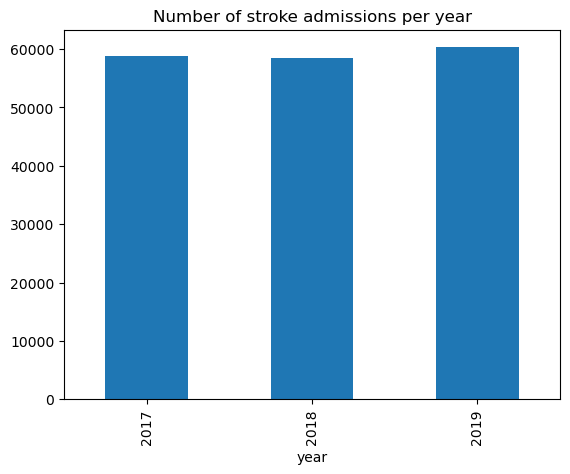

In [ ]:
# Admissions per year
yearly_admissions = data.groupby('year').size().reset_index(name='admissions')
yearly_admissions.plot.bar(x='year', y='admissions',
                           title='Number of stroke admissions per year',
                           legend=None)
plt.show()

In [ ]:
# Mean admissions per year
round(yearly_admissions['admissions'].mean(), 2)

59210.33

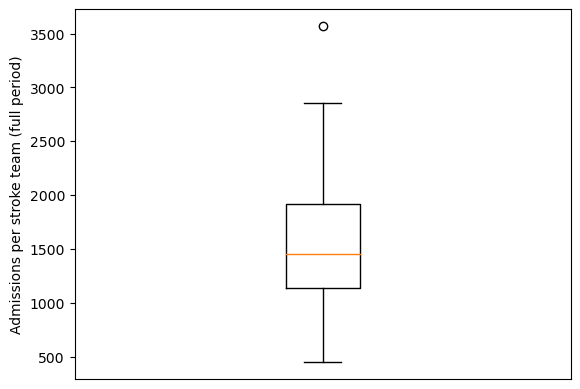

In [ ]:
# Admissions per stroke team
team_admissions = data.groupby('stroke_team').size()

# Plot distribution of admissions
plt.boxplot(team_admissions)
plt.ylabel('Admissions per stroke team (full period)')

# Remove x axis ticks as only one variable
plt.tick_params(axis='x', which='both', bottom=False,
                top=False, labelbottom=False)

plt.show()

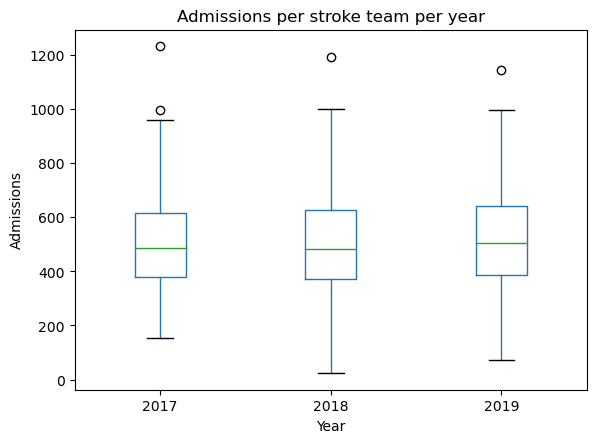

In [ ]:
# Find number of admissions per stroke team per year
team_admissions_yearly = (data
                          .groupby(['stroke_team', 'year'])
                          .size()
                          .reset_index(name='admissions'))

# Plot per year
team_admissions_yearly.boxplot('admissions', by='year')
plt.xlabel('Year')
plt.ylabel('Admissions')
plt.title('Admissions per stroke team per year')
plt.suptitle('')
plt.grid(None)
plt.show()

## Stroke types

In [ ]:
n_freq(data['infarction'].map({1: 'Infarction',
                               0: 'Primary Intracerebral Haemorrage'}))

,n,freq
Infarction,155367,0.874662
Primary Intracerebral Haemorrage,21546,0.121296
NaN,718,0.004042


## Thrombolysis and thrombectomy

In [ ]:
# Thrombolysis use
n_freq(data['thrombolysis'])

,n,freq
0,156836,0.882931
1,20795,0.117069


In [ ]:
# Thrombectomy use
n_freq(data['thrombectomy'])

,n,freq
0,175840,0.989917
1,1791,0.010083


In [ ]:
# Thrombolysis and/or thrombectomy use
n_freq(data[['thrombolysis', 'thrombectomy']]).sort_values(by='thrombolysis')

,thrombolysis,thrombectomy,n,freq
0,0,0,156141,0.879019
3,0,1,695,0.003913
1,1,0,19699,0.110898
2,1,1,1096,0.006170


In [ ]:
# Arrival by ambulance
n_freq(data['arrive_by_ambulance'])

,n,freq
1,139837,0.787233
0,37794,0.212767


In [ ]:
# Thrombolysis use, depending on whether arrived by ambulance
(n_freq(data.groupby('arrive_by_ambulance')['thrombolysis'])
 .sort_values(by='arrive_by_ambulance'))

,arrive_by_ambulance,thrombolysis,n,freq
0,0,0,36287,0.960126
1,0,1,1507,0.039874
2,1,0,120549,0.862068
3,1,1,19288,0.137932


## Reasons for no thrombolysis

It is possible to have multiple reasons why no thrombolysis was given.

To do:
* What are the most common reasons
* How often is it a combination of reasons
* How often is no reason provided
* Double-check this is only complete when there was no thrombolysis
* Look further (e.g. subgroups, characteristics, associations)

In [ ]:
(data[[col for col in data if col.startswith('thrombolysis_no')]]
 .value_counts(dropna=False)
 .reset_index(name='count'))

,thrombolysis_no_but_haemorrhagic,thrombolysis_no_but_time_window,thrombolysis_no_but_comorbidity,thrombolysis_no_but_medication,thrombolysis_no_but_refusal,thrombolysis_no_but_age,thrombolysis_no_but_improving,thrombolysis_no_but_too_mild_severe,thrombolysis_no_but_time_unknown_wake_up,thrombolysis_no_but_other_medical,thrombolysis_no_not_available,thrombolysis_no_out_of_hours,thrombolysis_no_scan_not_quick_enough,thrombolysis_no_no_reason,count
0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,36882
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,36382
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,21270
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20795
4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,8981
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,1,0,0,0,0,0,1,1,0,1,0,0,0,0,1
247,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1
248,1,0,0,1,0,0,0,1,1,0,0,0,0,0,1
249,1,0,0,1,0,0,1,1,0,0,0,0,0,0,1


## Disability at 6 months

Currently, outcome models are just based on discharge disability. The majority of patients are missing disability at 6 months - but this is not likely to be missing at random.

In [ ]:
# tbc
# e.g. disability at discharge v.s. at 6 months, is it typically 1 mRS better

## Rough notes

In [ ]:
# Rough notes

'''
# Arrival times
data['weekday'].value_counts()

data['month'].value_counts().sort_index()

data['year'].value_counts().sort_index()

data['arrival_time_3_hour_period'].value_counts().sort_index()

# Analyse by team - group by team, record:
# Team, admission numbers, thrombolysis rate, rank before stroke, NIHSS on arrival, proportion with known onset time (remove rest), proportion with onset <4 (remove rest)
# rankin again, proportion 80+, onset to arrival, scan within 4 hours, arrival to scan, thrombolysis given, scan to needle, arrival to needle, onset to needle, proportion thrombolysis after 180 or 270

# Based on analysis by team, summarise for whole population (average of each hospital)

# Those average summary results for under 80 v.s. over 80

# Figure with thrombolyysis use (all and < 4 hours onset)
# Figure proportion with known onset
# Mean arrival to scan time for patients
# Mean scan to needle time
# Mean arrival to needle time

# Stroke severity distribution

# Onset to arrival, proportion known onset, severity

# Restrict to patients who received thrombolysis
thrombolysed = data[data['thrombolysis'] == 1].copy()

# Proportion where onset is known
# throm_arrival['onset known'] = thrombolysed['onset known'].value_counts(normalize = True)[1]

# Arrival within 4 or 6 hours
thrombolysed['arrive_within_4'] = np.where(thrombolysed['onset_to_arrival_time'] <= 240, 1, 0)
thrombolysed['arrive_within_6'] = np.where(thrombolysed['onset_to_arrival_time'] <= 360, 1, 0)

# NIHSS 6+ or 11+
thrombolysed['nihss_6_plus'] = np.where(thrombolysed['stroke_severity'] >= 6, 1, 0)
thrombolysed['nihss_11_plus'] = np.where(thrombolysed['stroke_severity'] >= 11, 1, 0)

# Find results overall, by arrival time group, and by NIHSS group
# thrombolysed.groupby('arrive_within_4').mean()
'''


"\n# Arrival times\ndata['weekday'].value_counts()\n\ndata['month'].value_counts().sort_index()\n\ndata['year'].value_counts().sort_index()\n\ndata['arrival_time_3_hour_period'].value_counts().sort_index()\n\n# Analyse by team - group by team, record:\n# Team, admission numbers, thrombolysis rate, rank before stroke, NIHSS on arrival, proportion with known onset time (remove rest), proportion with onset <4 (remove rest)\n# rankin again, proportion 80+, onset to arrival, scan within 4 hours, arrival to scan, thrombolysis given, scan to needle, arrival to needle, onset to needle, proportion thrombolysis after 180 or 270\n\n# Based on analysis by team, summarise for whole population (average of each hospital)\n\n# Those average summary results for under 80 v.s. over 80\n\n# Figure with thrombolyysis use (all and < 4 hours onset)\n# Figure proportion with known onset\n# Mean arrival to scan time for patients\n# Mean scan to needle time\n# Mean arrival to needle time\n\n# Stroke severity di

14:80: E501 line too long (170 > 79 characters)
15:80: E501 line too long (200 > 79 characters)
17:80: E501 line too long (86 > 79 characters)
35:80: E501 line too long (94 > 79 characters)
38:80: E501 line too long (94 > 79 characters)
39:80: E501 line too long (94 > 79 characters)
42:80: E501 line too long (83 > 79 characters)
43:80: E501 line too long (85 > 79 characters)
48:1: W391 blank line at end of file
